In [14]:
# --- 1. 請在此輸入您的實驗數據 ---

# 0.1 N HNO3 實驗數據
data_01N = {
    'Time (min)': [0, 10, 20, 30, 40, 50, 60],
    'Absorbance': [0.37154, 0.34453, 0.29889, 0.27272, 0.25037, 0.24429, 0.24207]
}

# 0.3 N HNO3 實驗數據
data_03N = {
    'Time (min)': [0, 10, 20, 30, 40, 50, 60],
    'Absorbance': [0.36401, 0.33132, 0.28623, 0.25663, 0.24152, 0.23152, 0.23007]
}


# --- 2. 手動設定最終吸光度 (可選) ---
# 程式預設會使用您數據中的最後一個點作為 A_inf (最終吸光度)。
# 如果您想手動指定 A_inf (例如，使用講義提供的公式計算值)，請在此修改。
# 設為 None 則使用數據最後一點。
A_inf_01N_manual = None
A_inf_03N_manual = None

--- 0.1 N HNO3 數據設定 ---
A0 (初始吸光度) = 0.37154
A_inf (最終吸光度) = 0.24207

--- 0.3 N HNO3 數據設定 ---
A0 (初始吸光度) = 0.36401
A_inf (最終吸光度) = 0.23007

--- 0.1 N HNO3 系列圖 ---


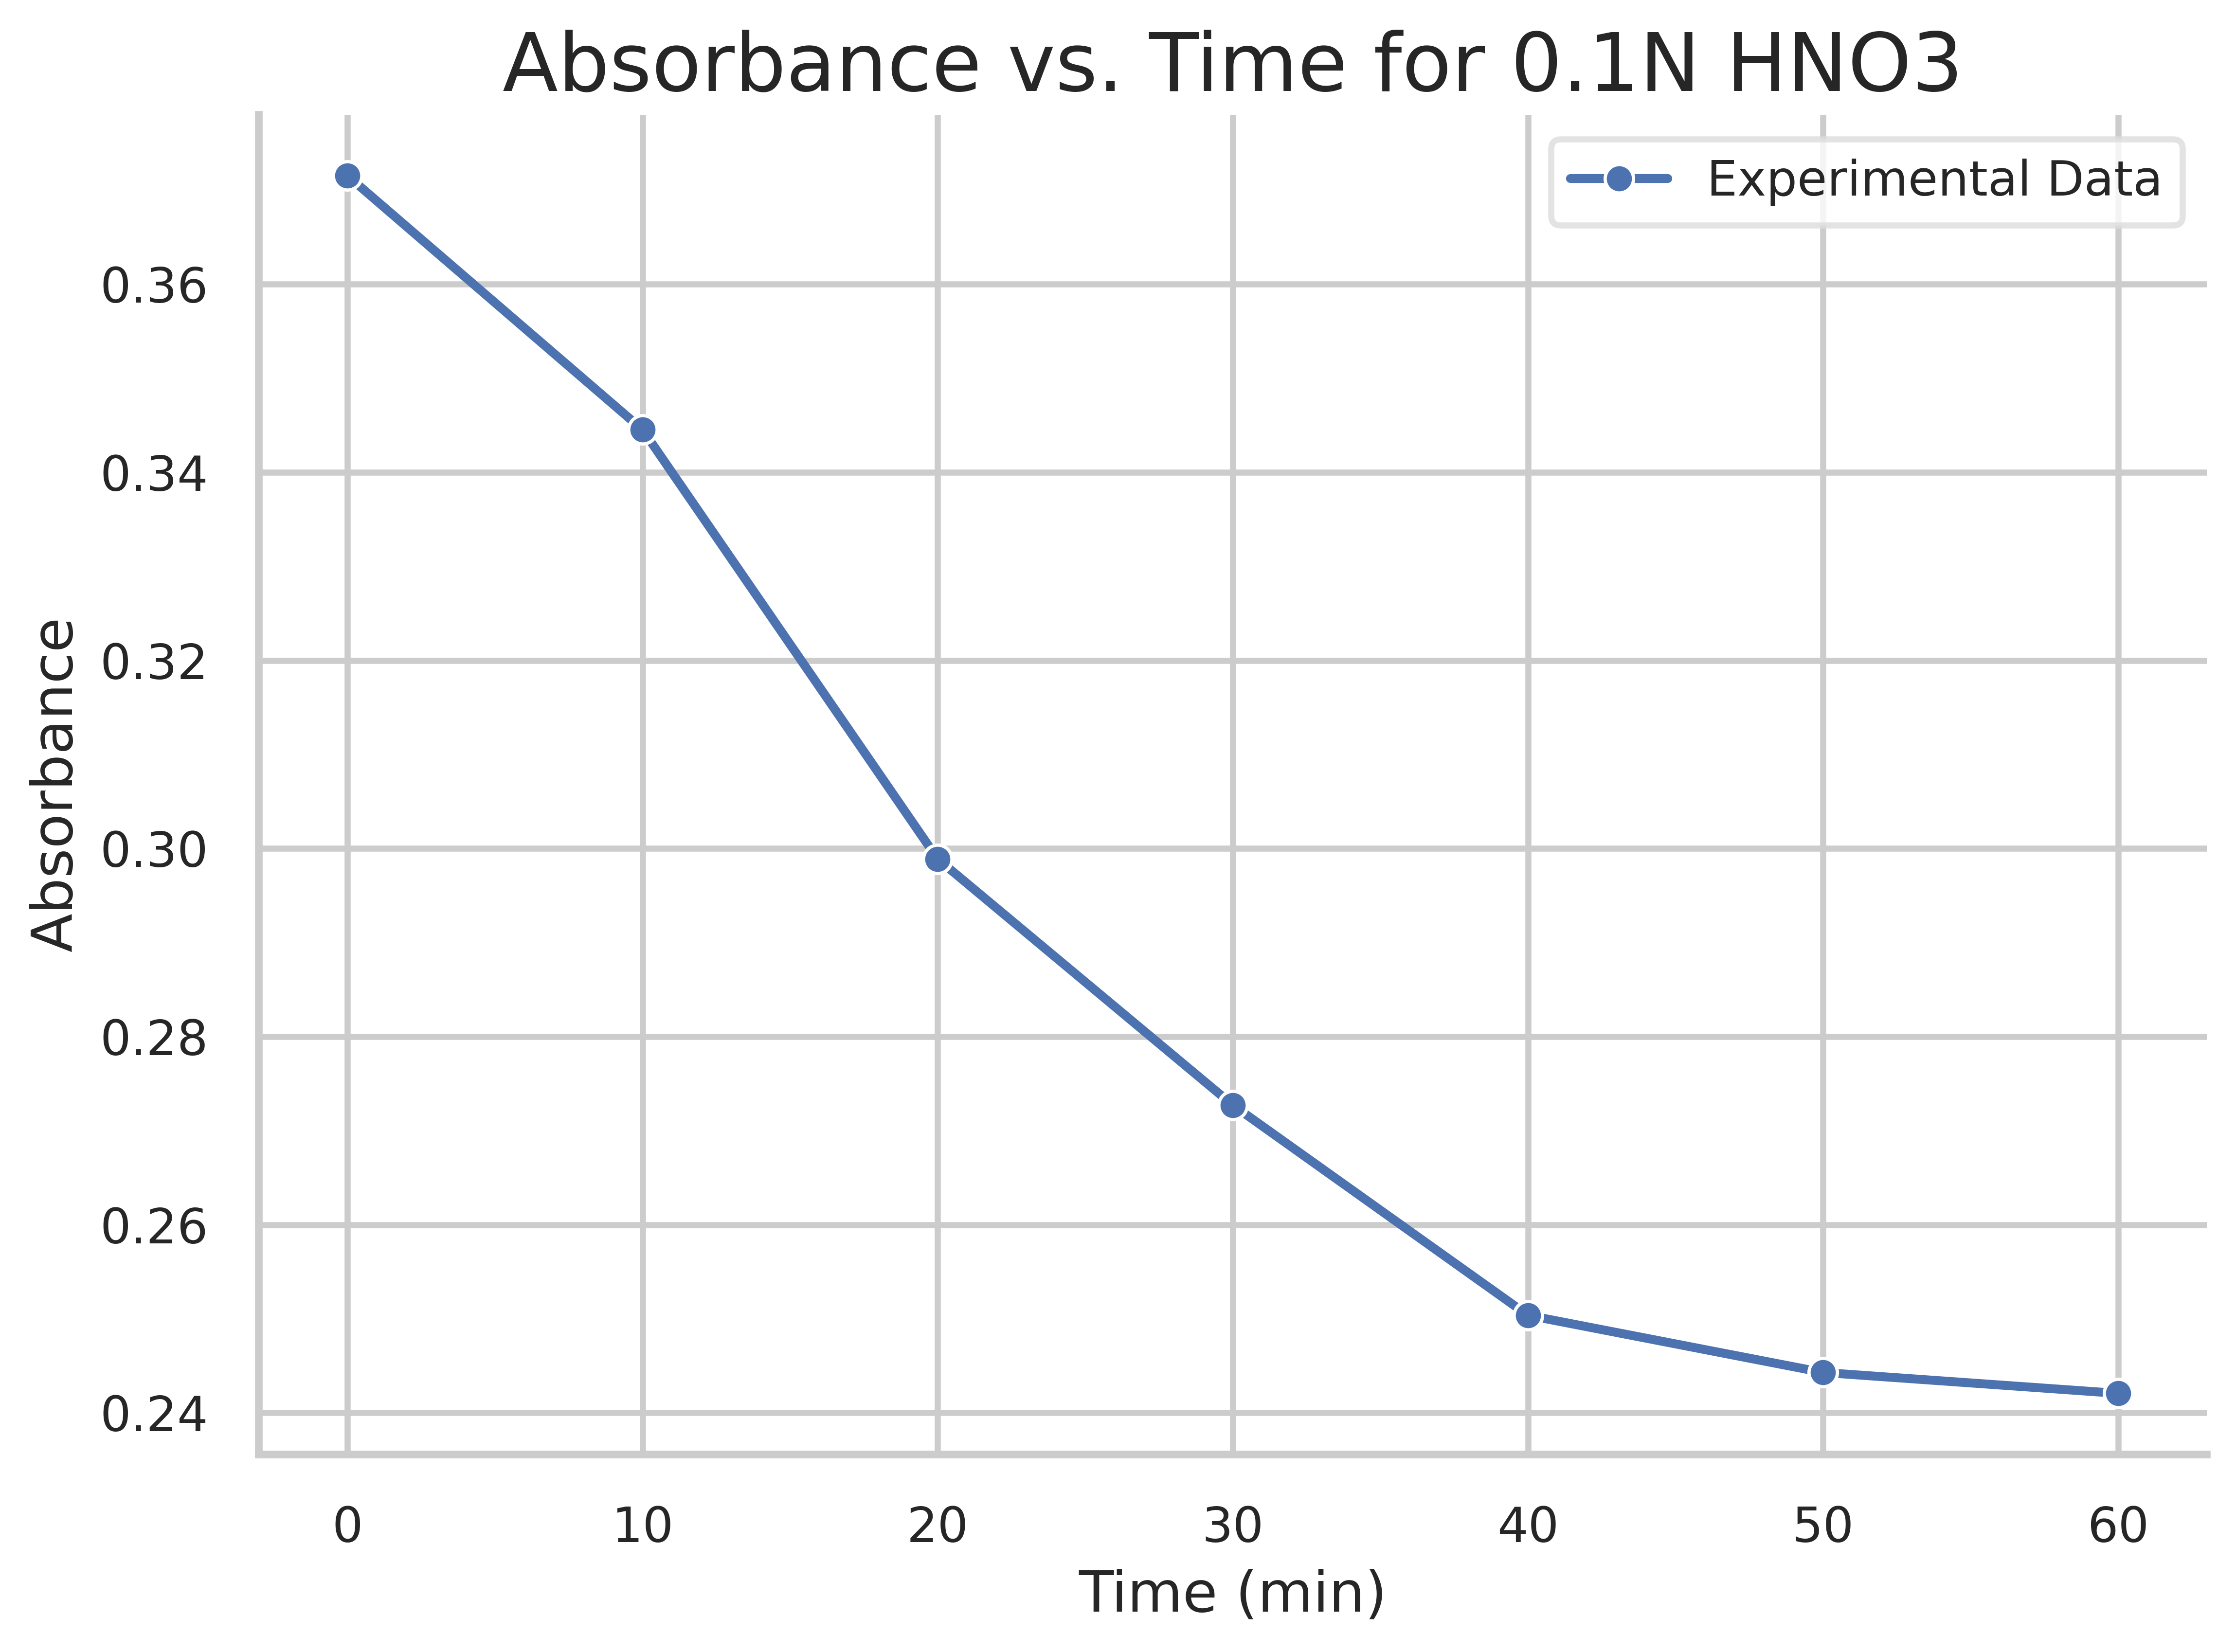

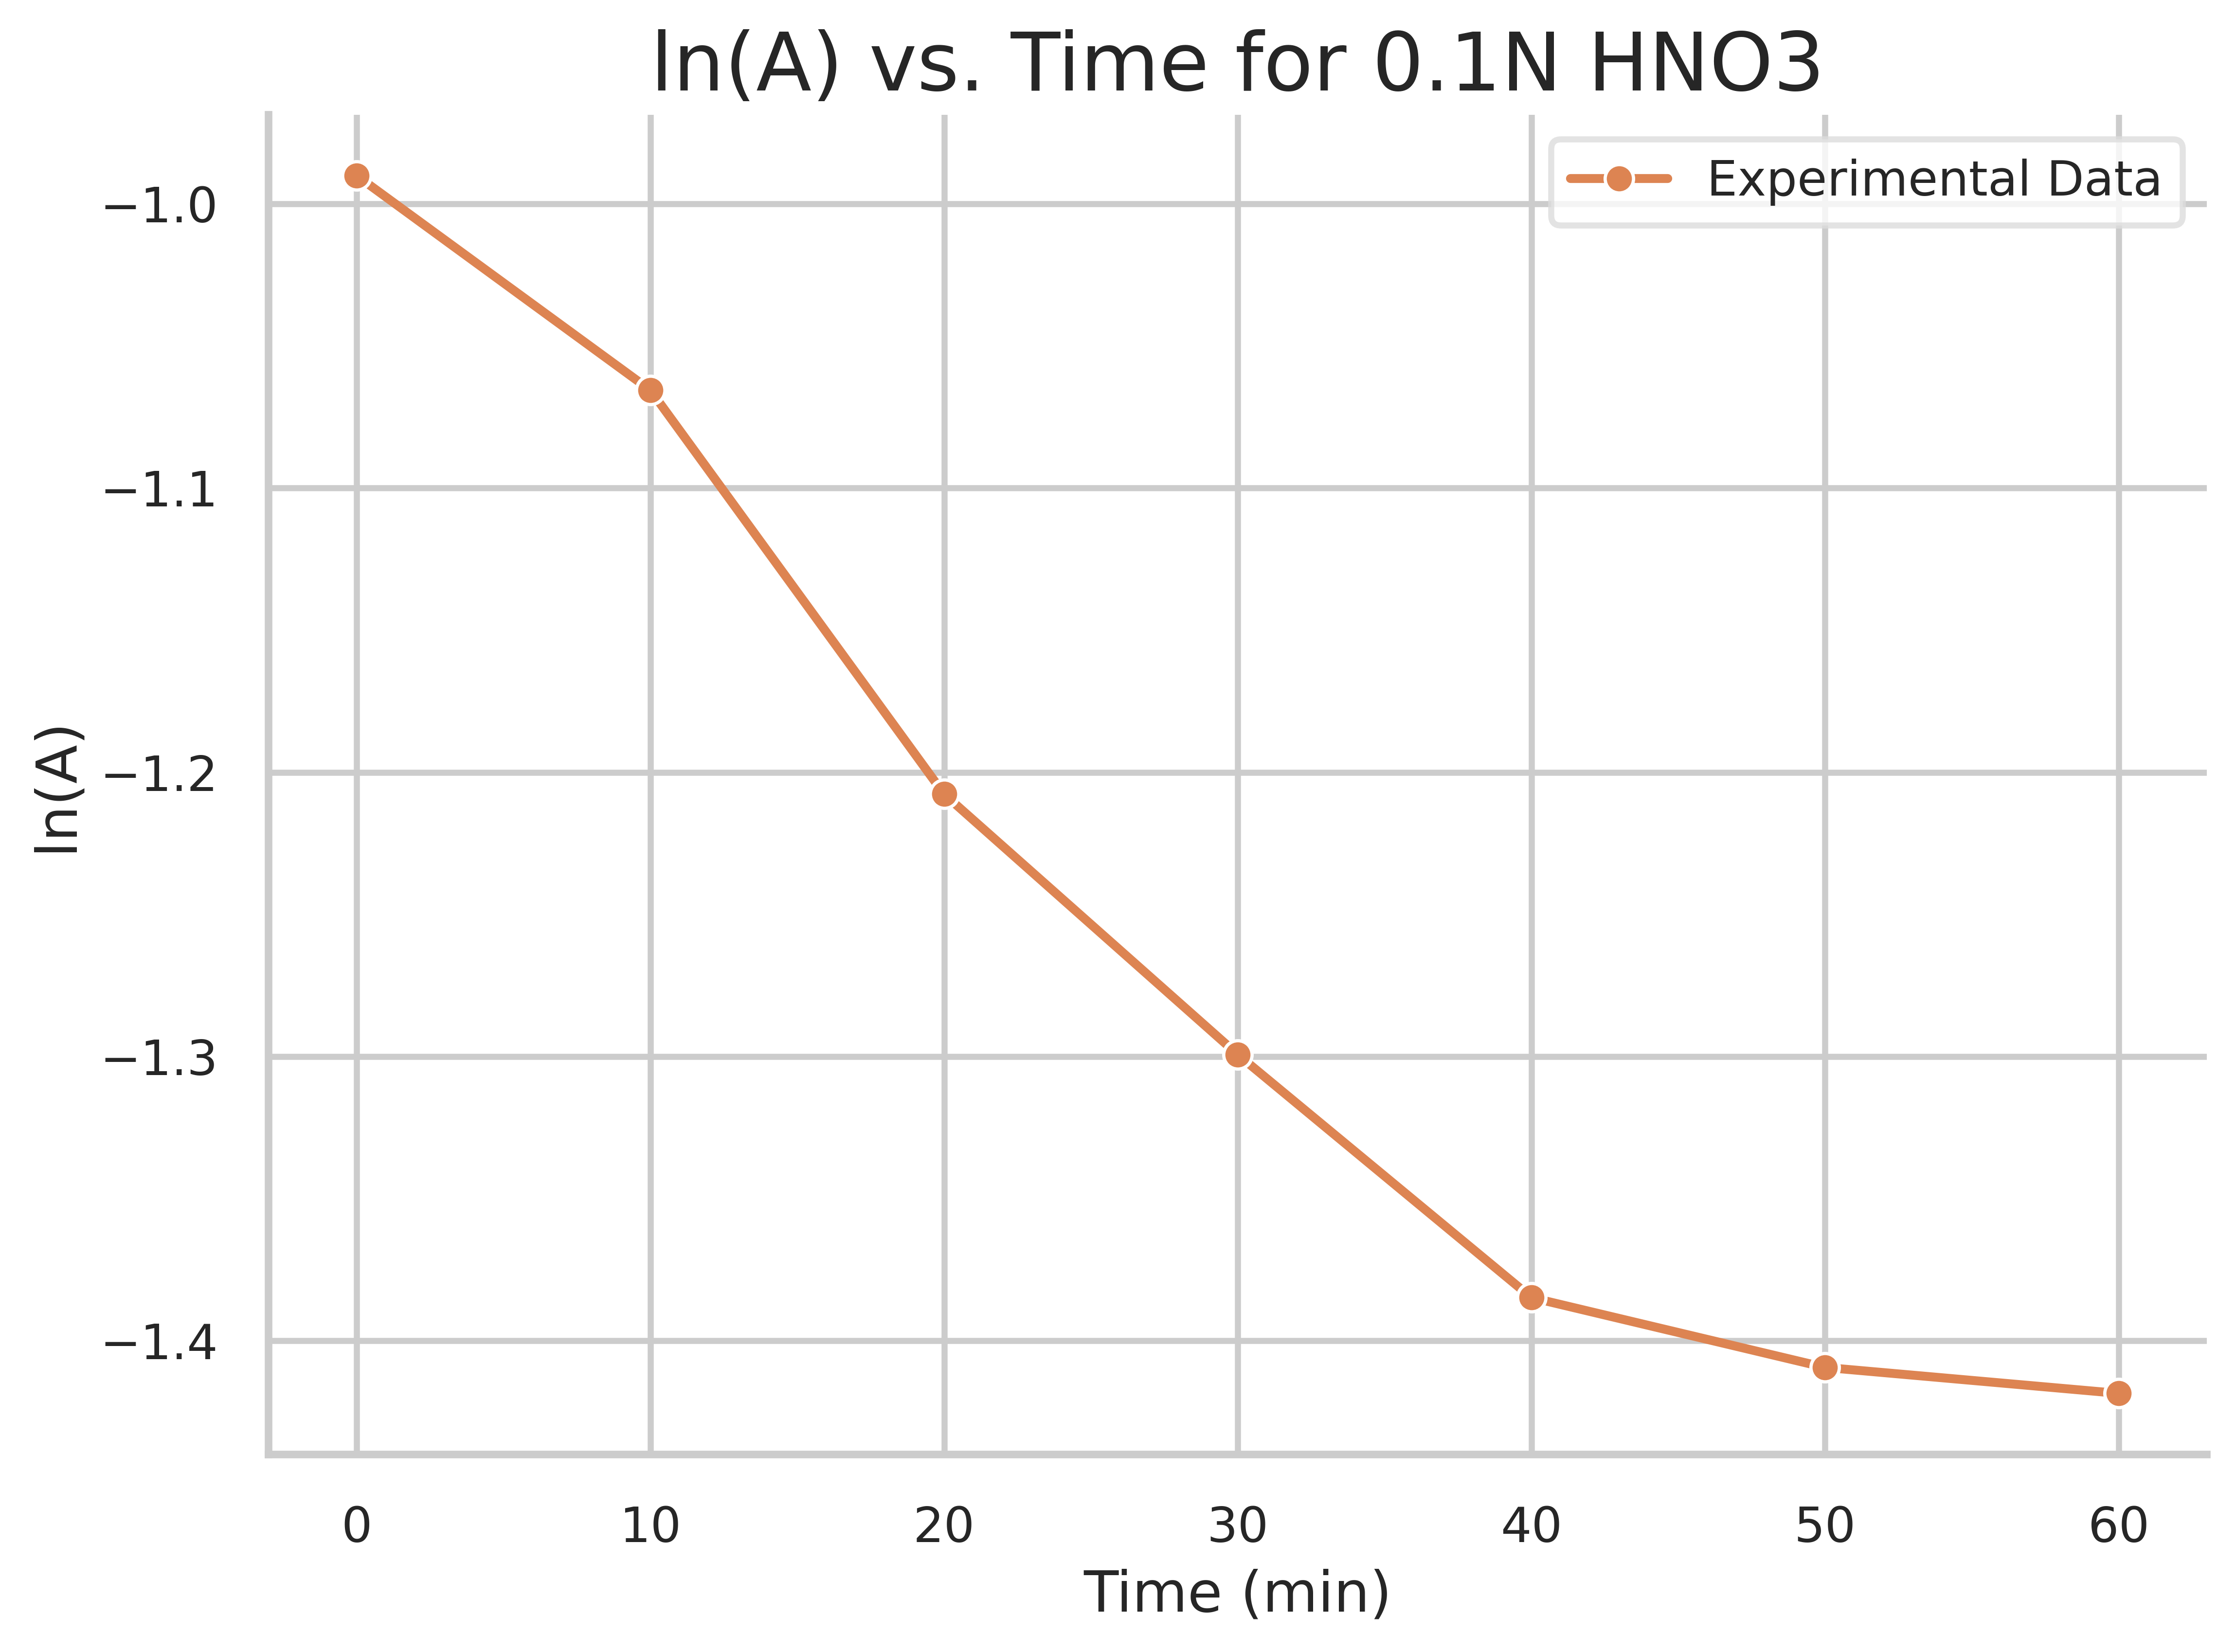

--- 分析報告: ln(A - A_inf) vs. Time for 0.1N HNO3 ---
  (已排除首尾數據點進行計算)
斜率 (slope): -0.08157
速率常數 k_obs = 0.08157 (min⁻¹)
R-squared 值: 0.9568



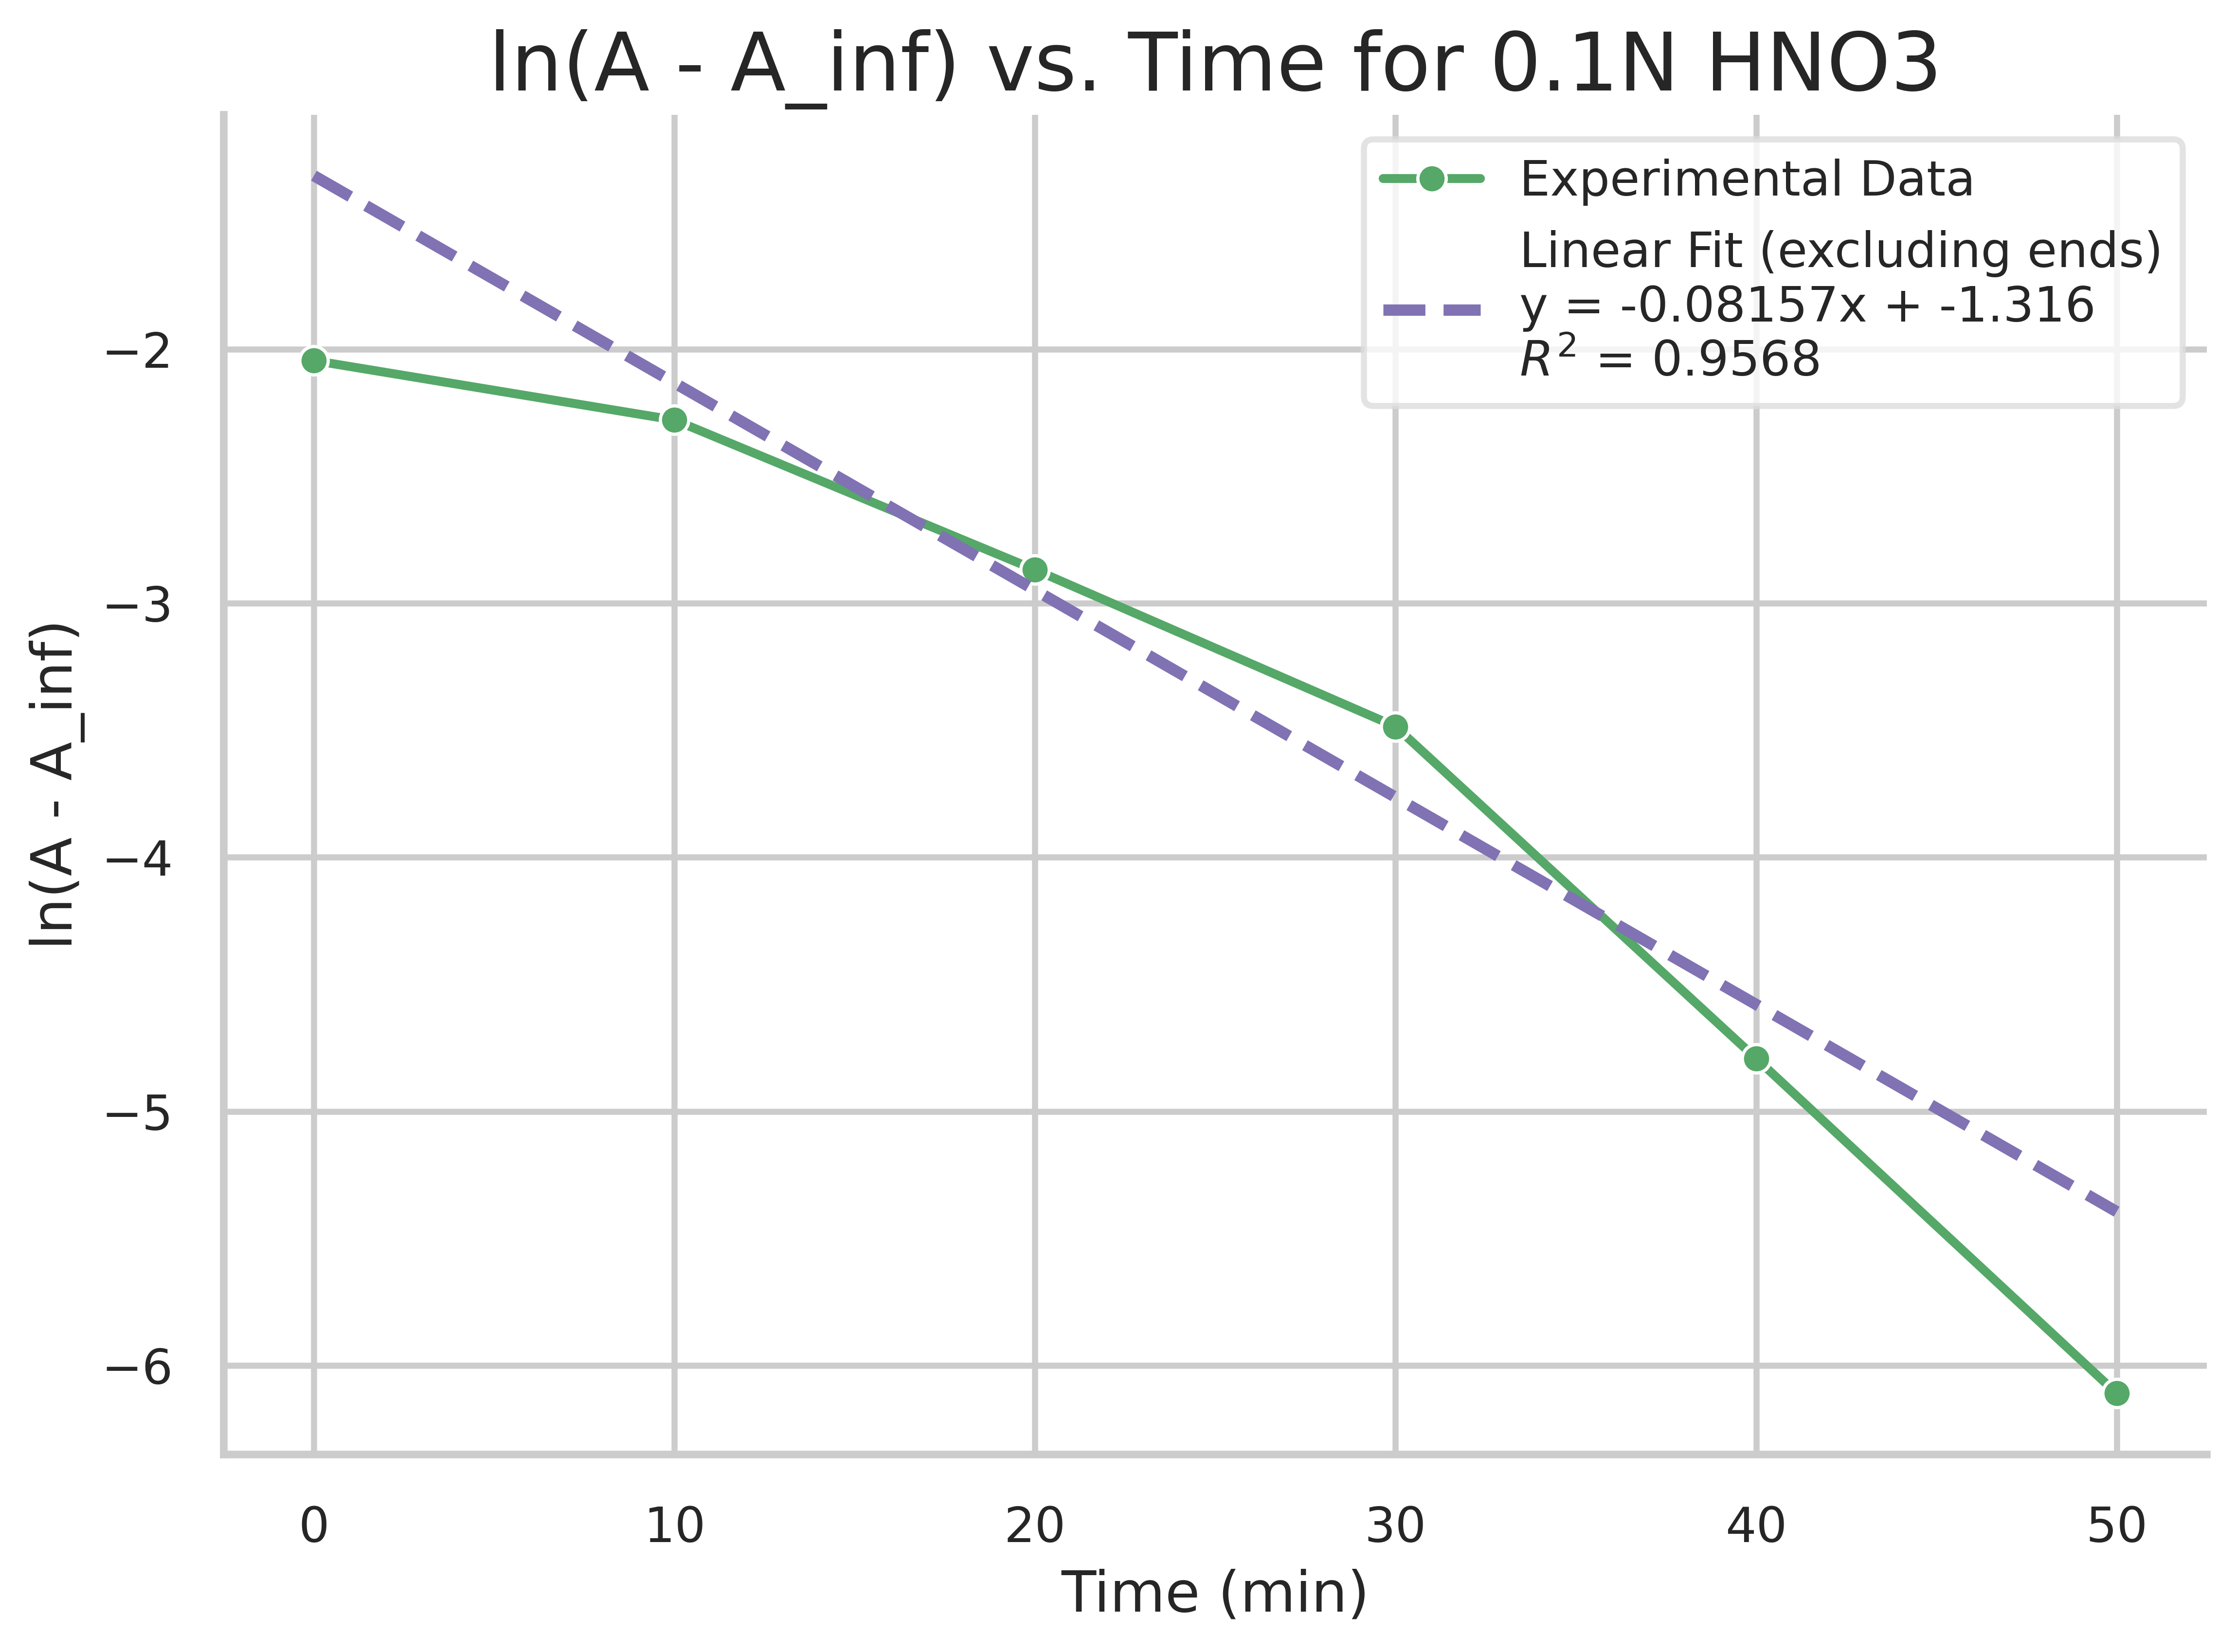

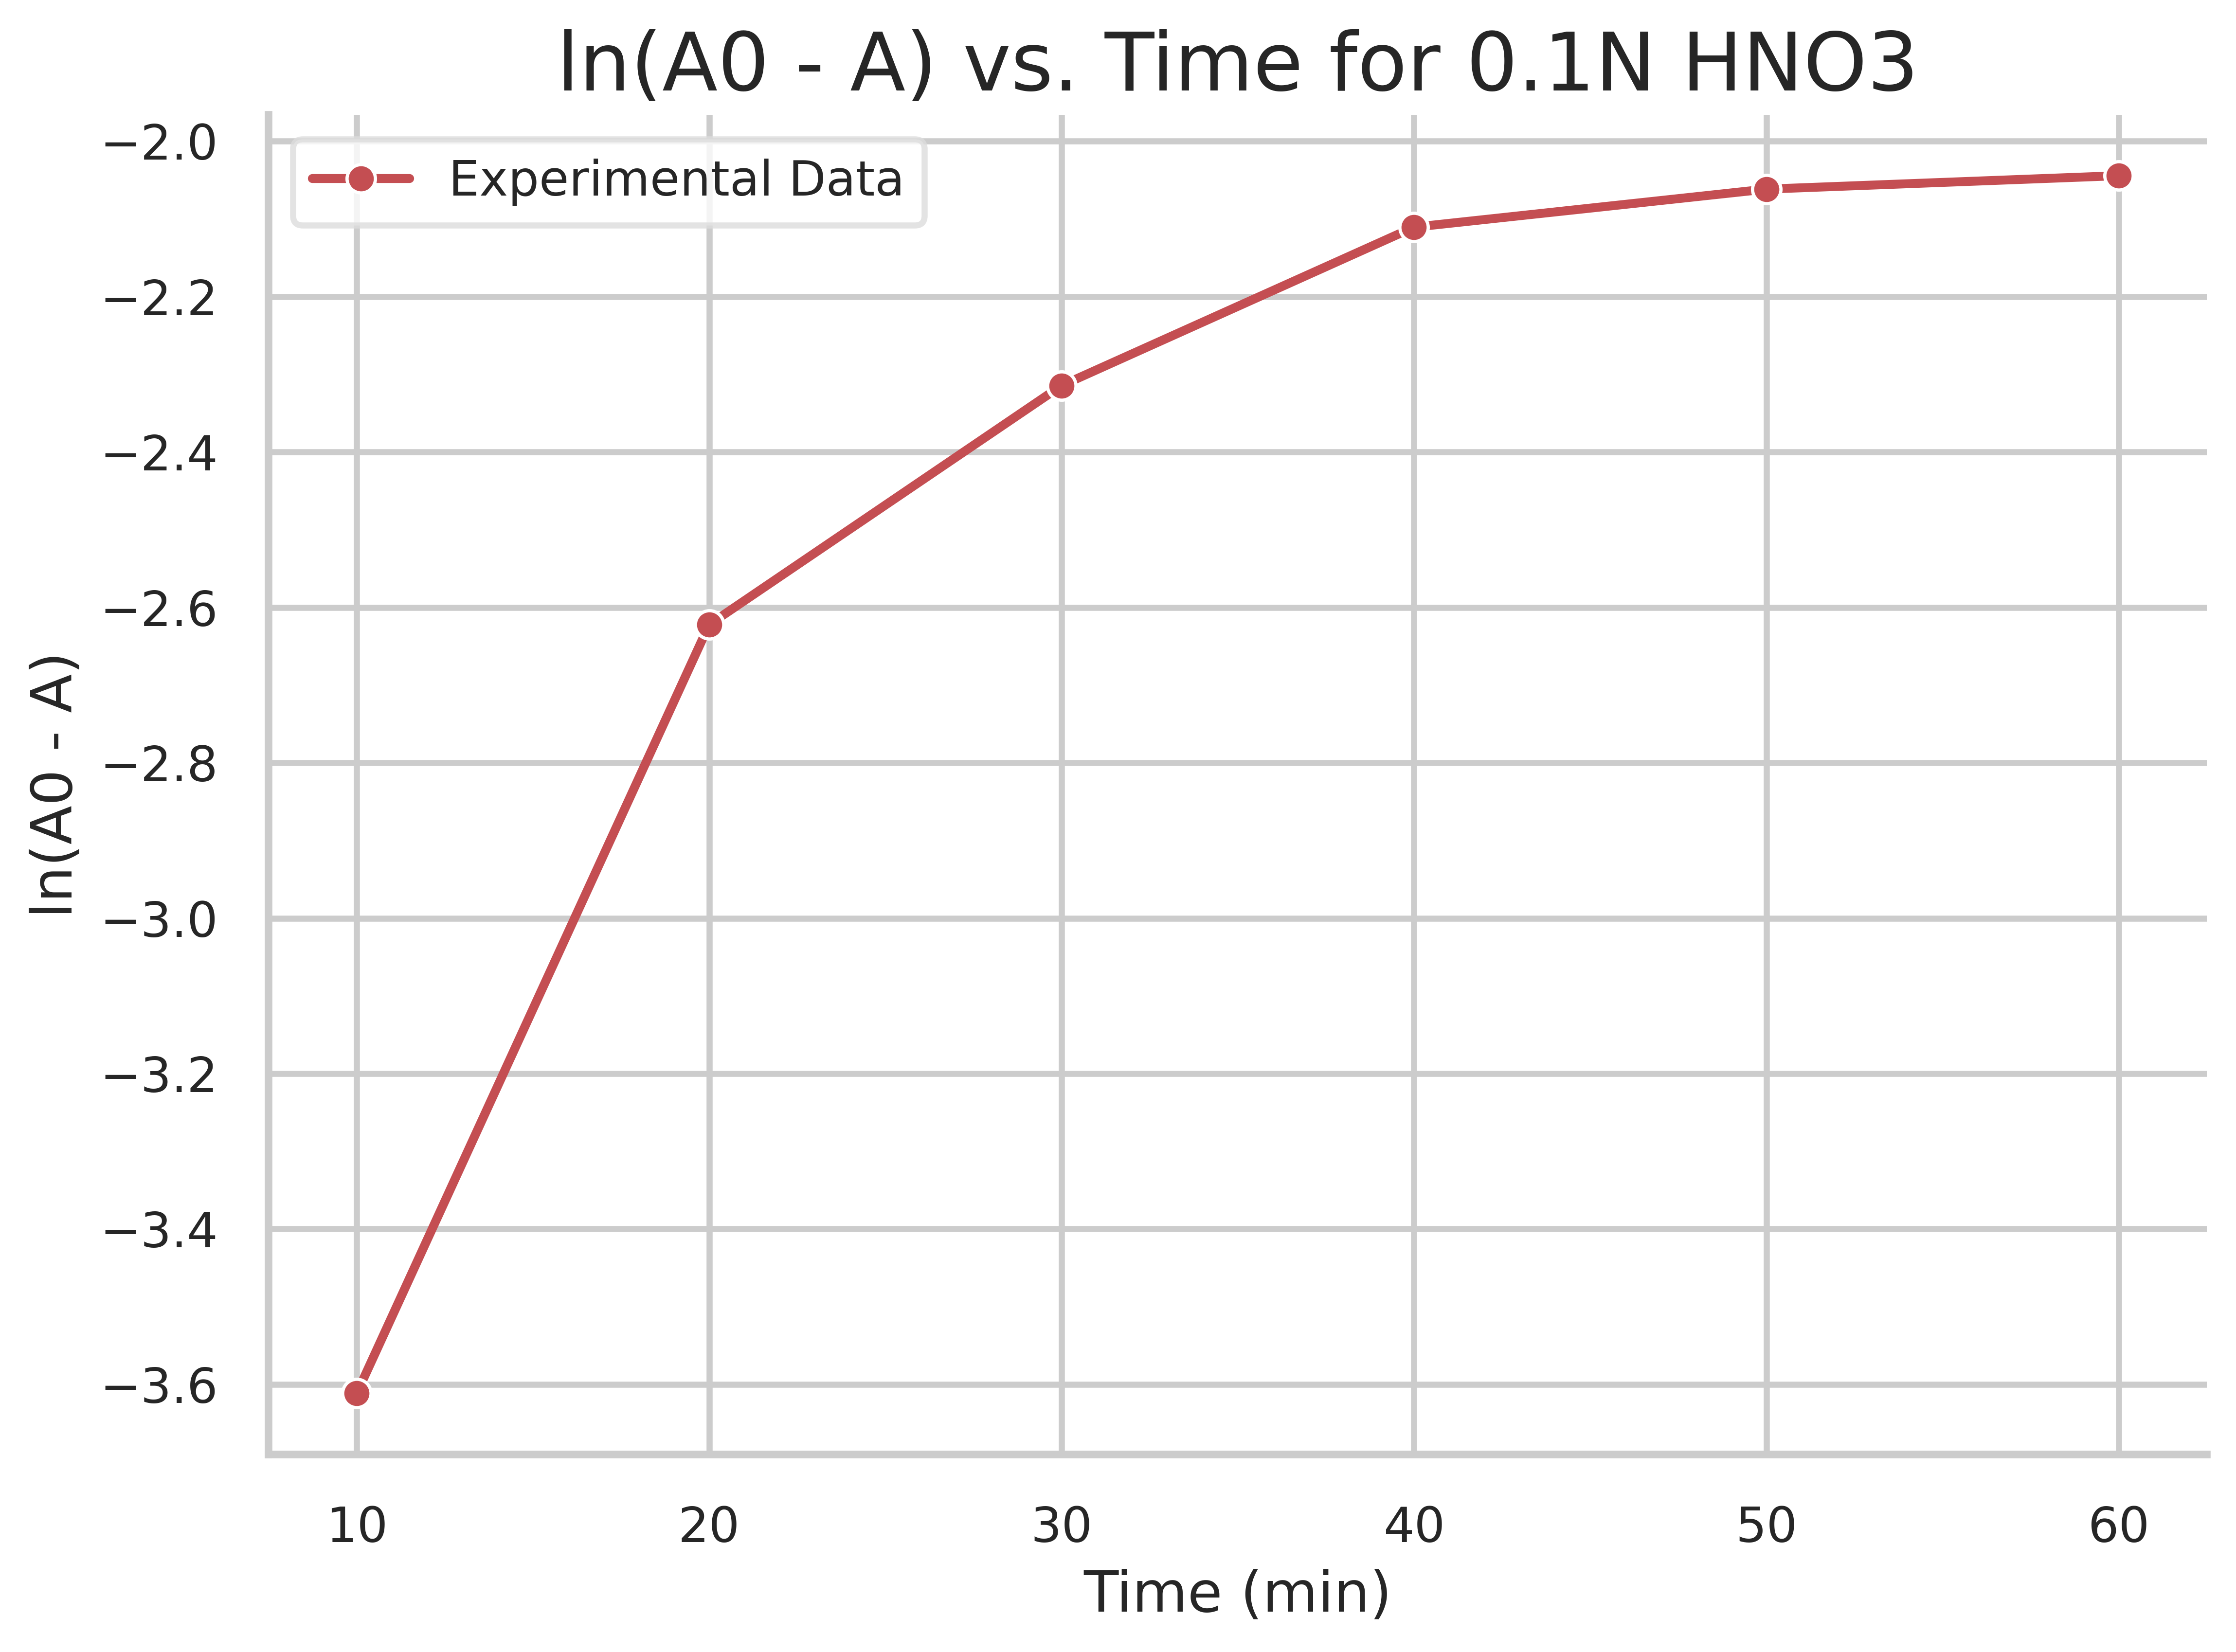


--- 0.3 N HNO3 系列圖 ---


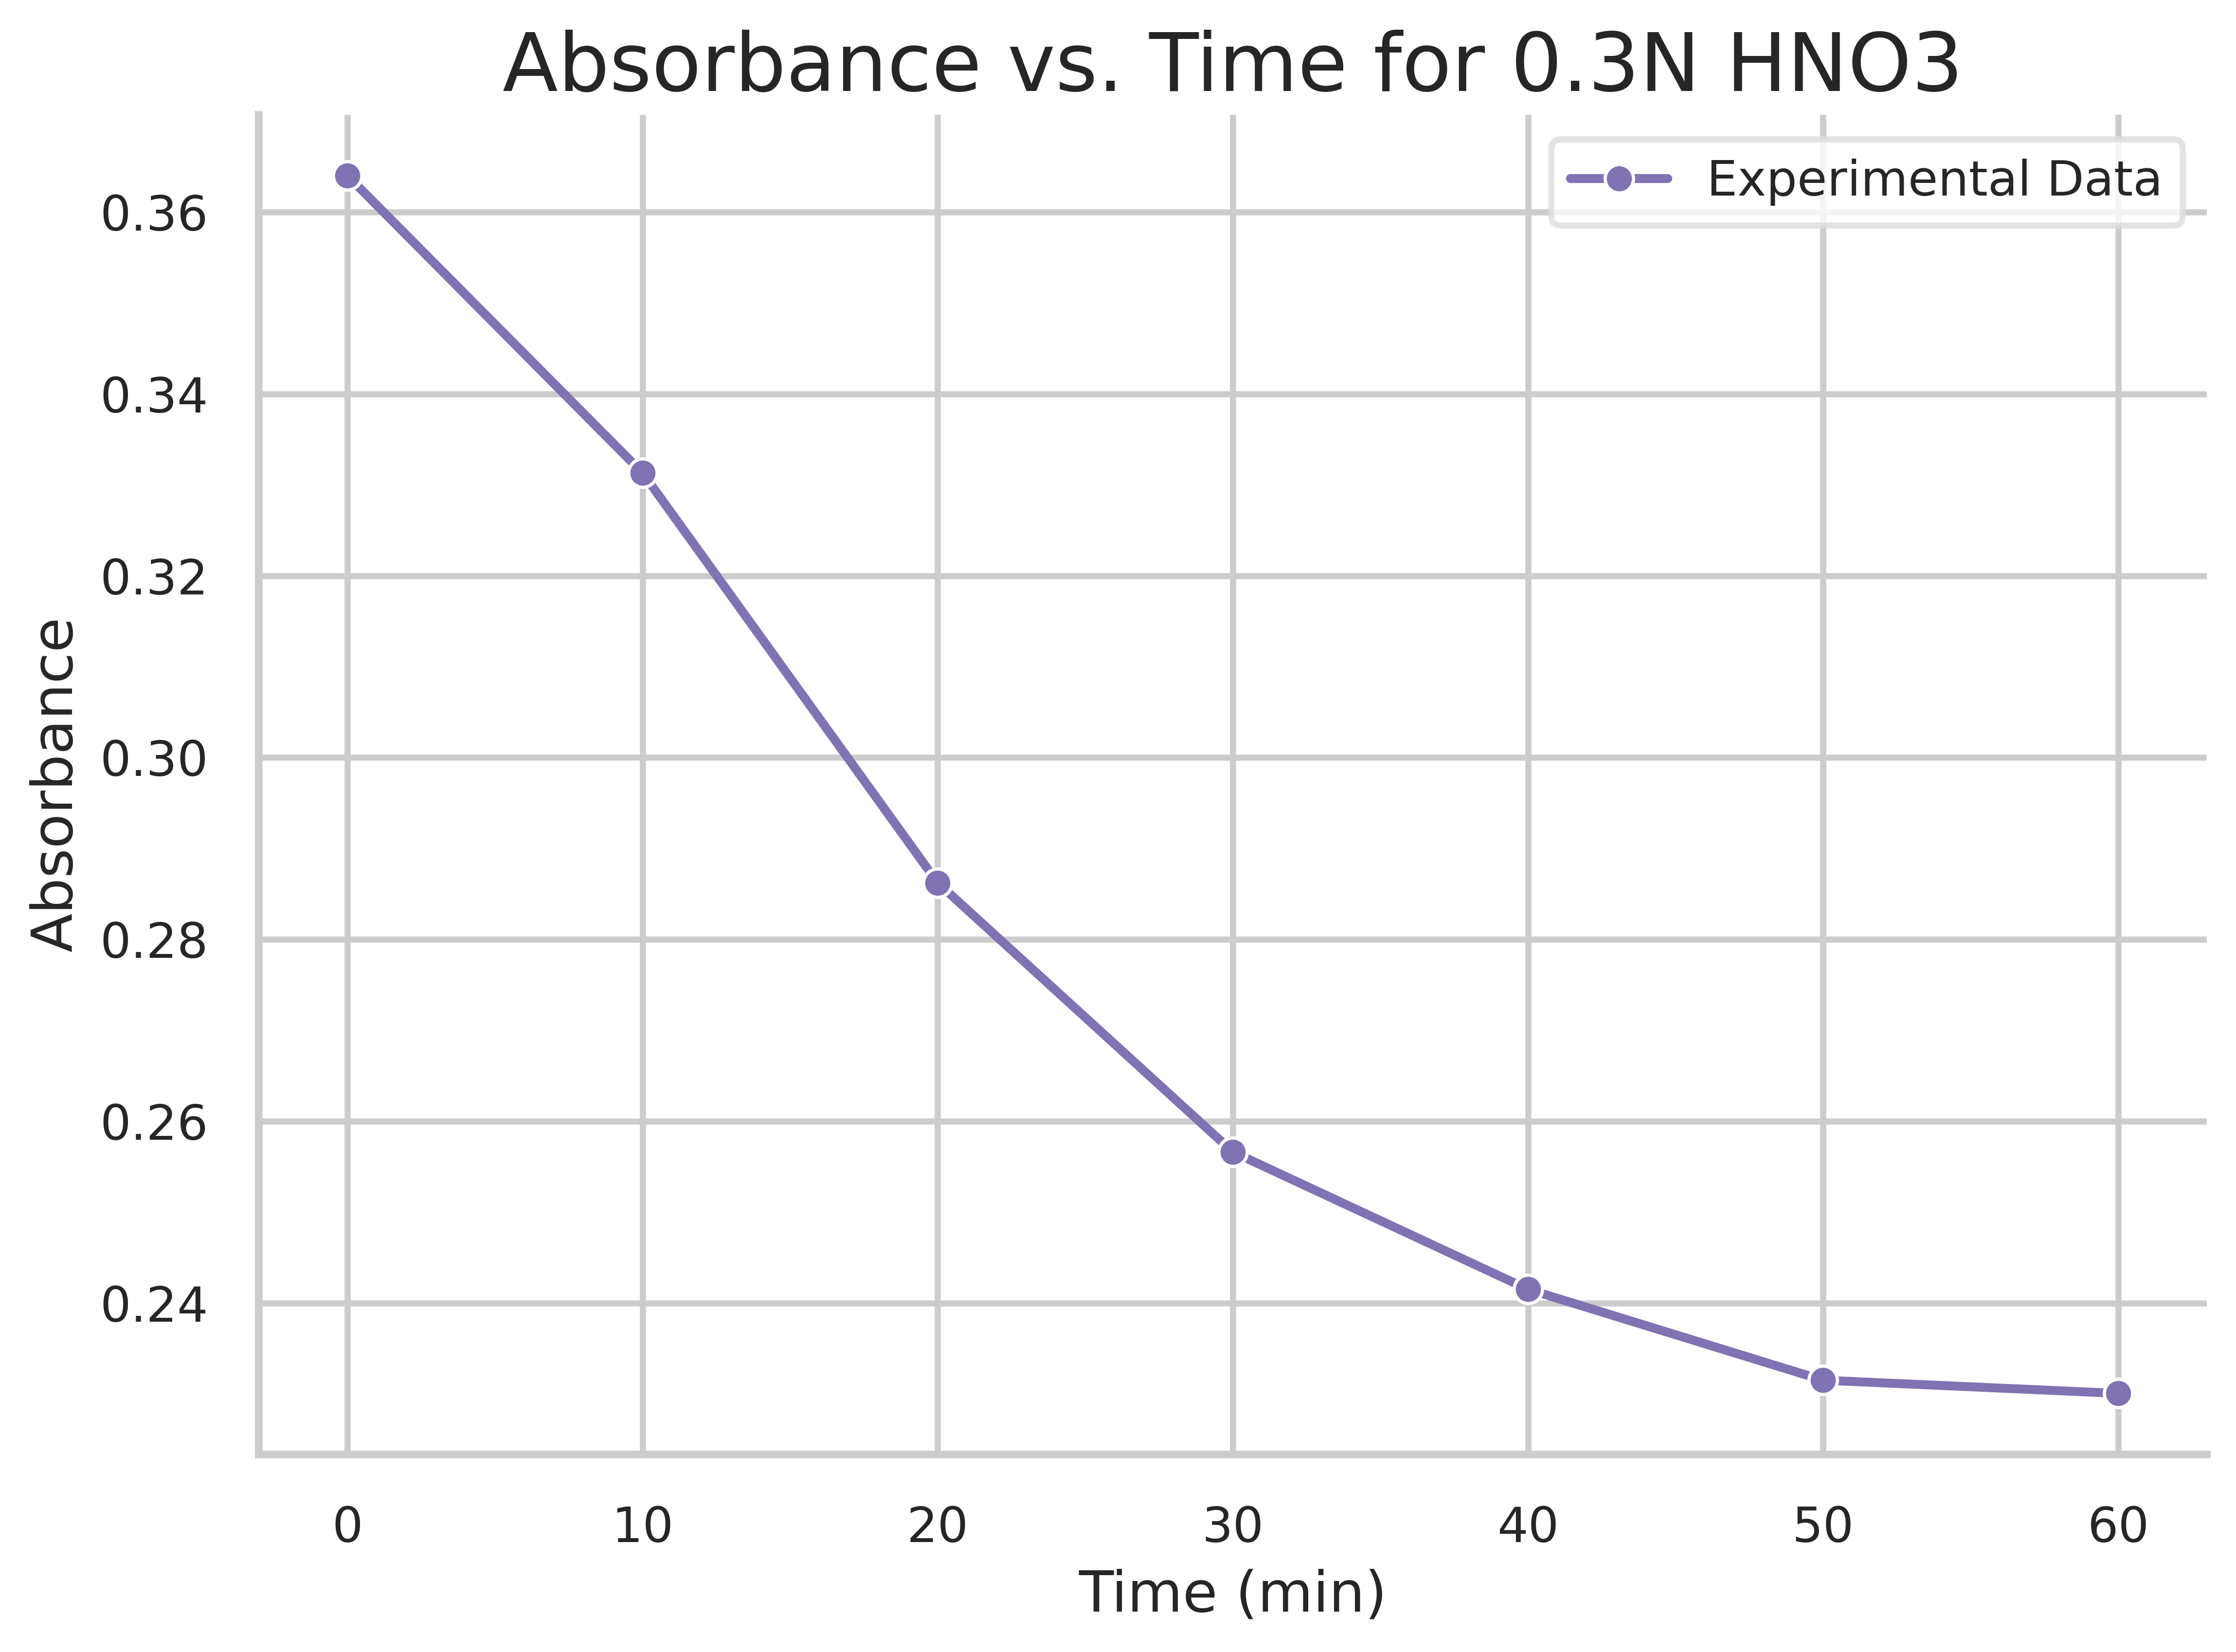

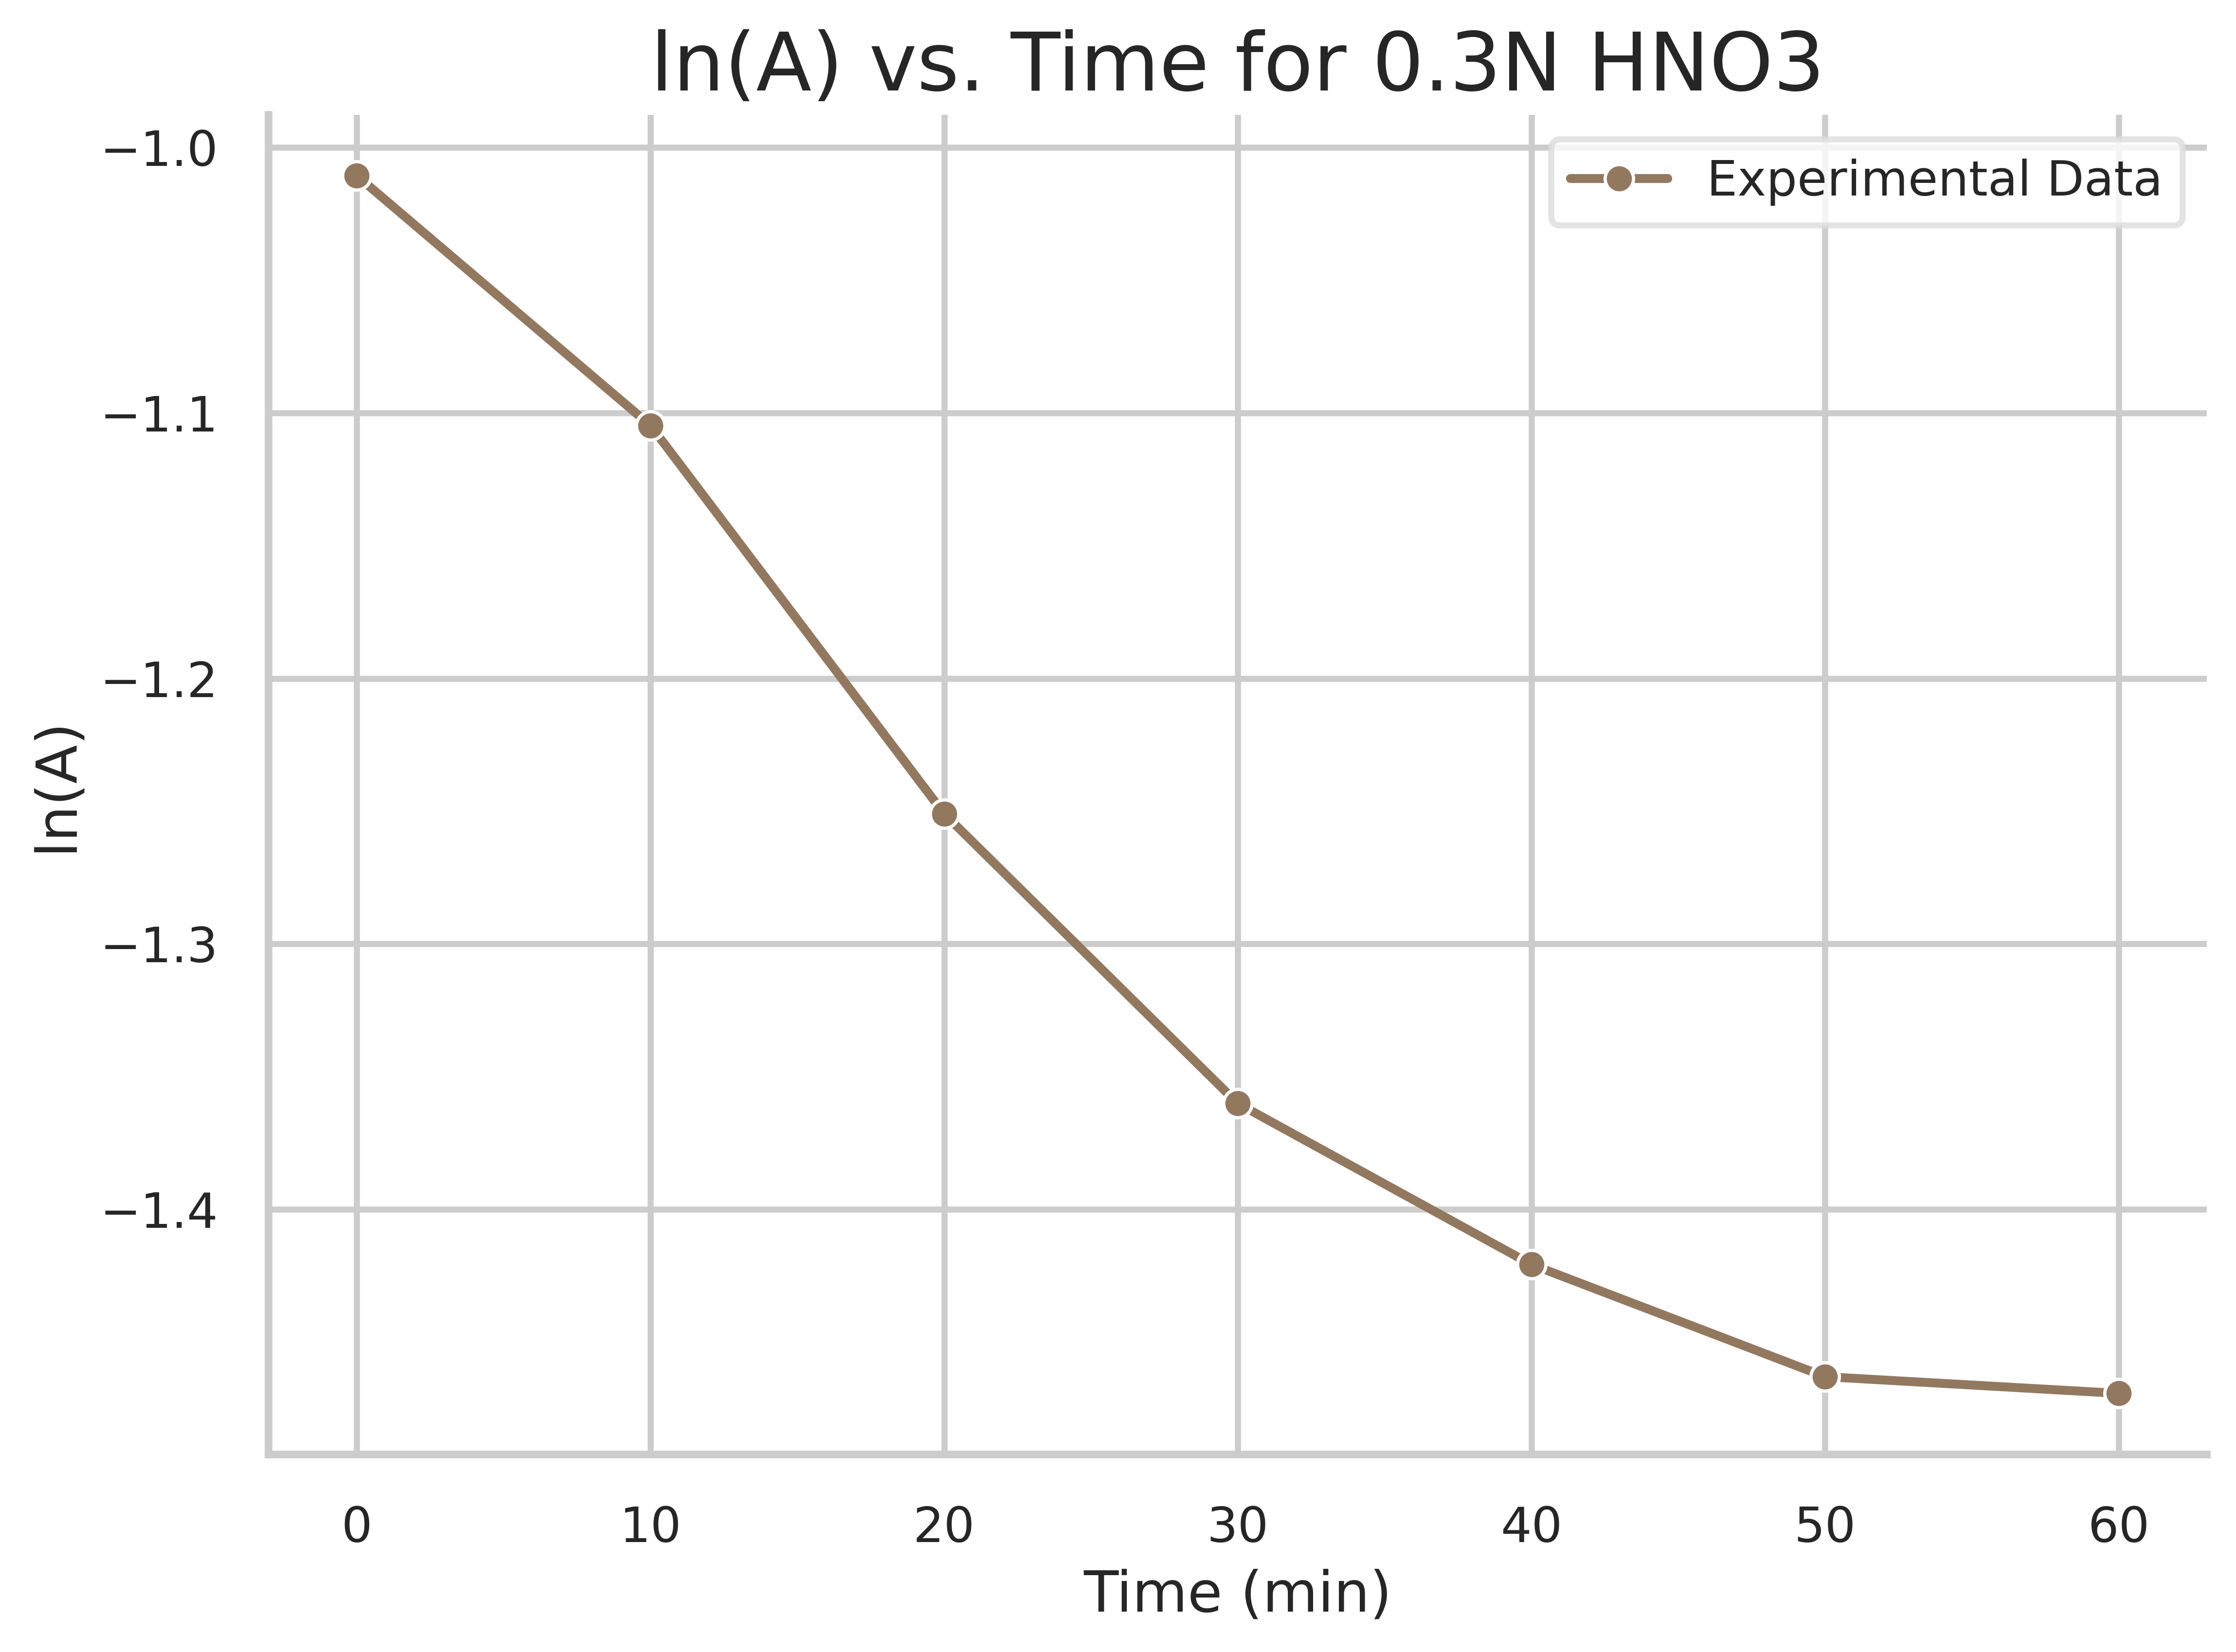

--- 分析報告: ln(A - A_inf) vs. Time for 0.3N HNO3 ---
  (已排除首尾數據點進行計算)
斜率 (slope): -0.07288
速率常數 k_obs = 0.07288 (min⁻¹)
R-squared 值: 0.9940



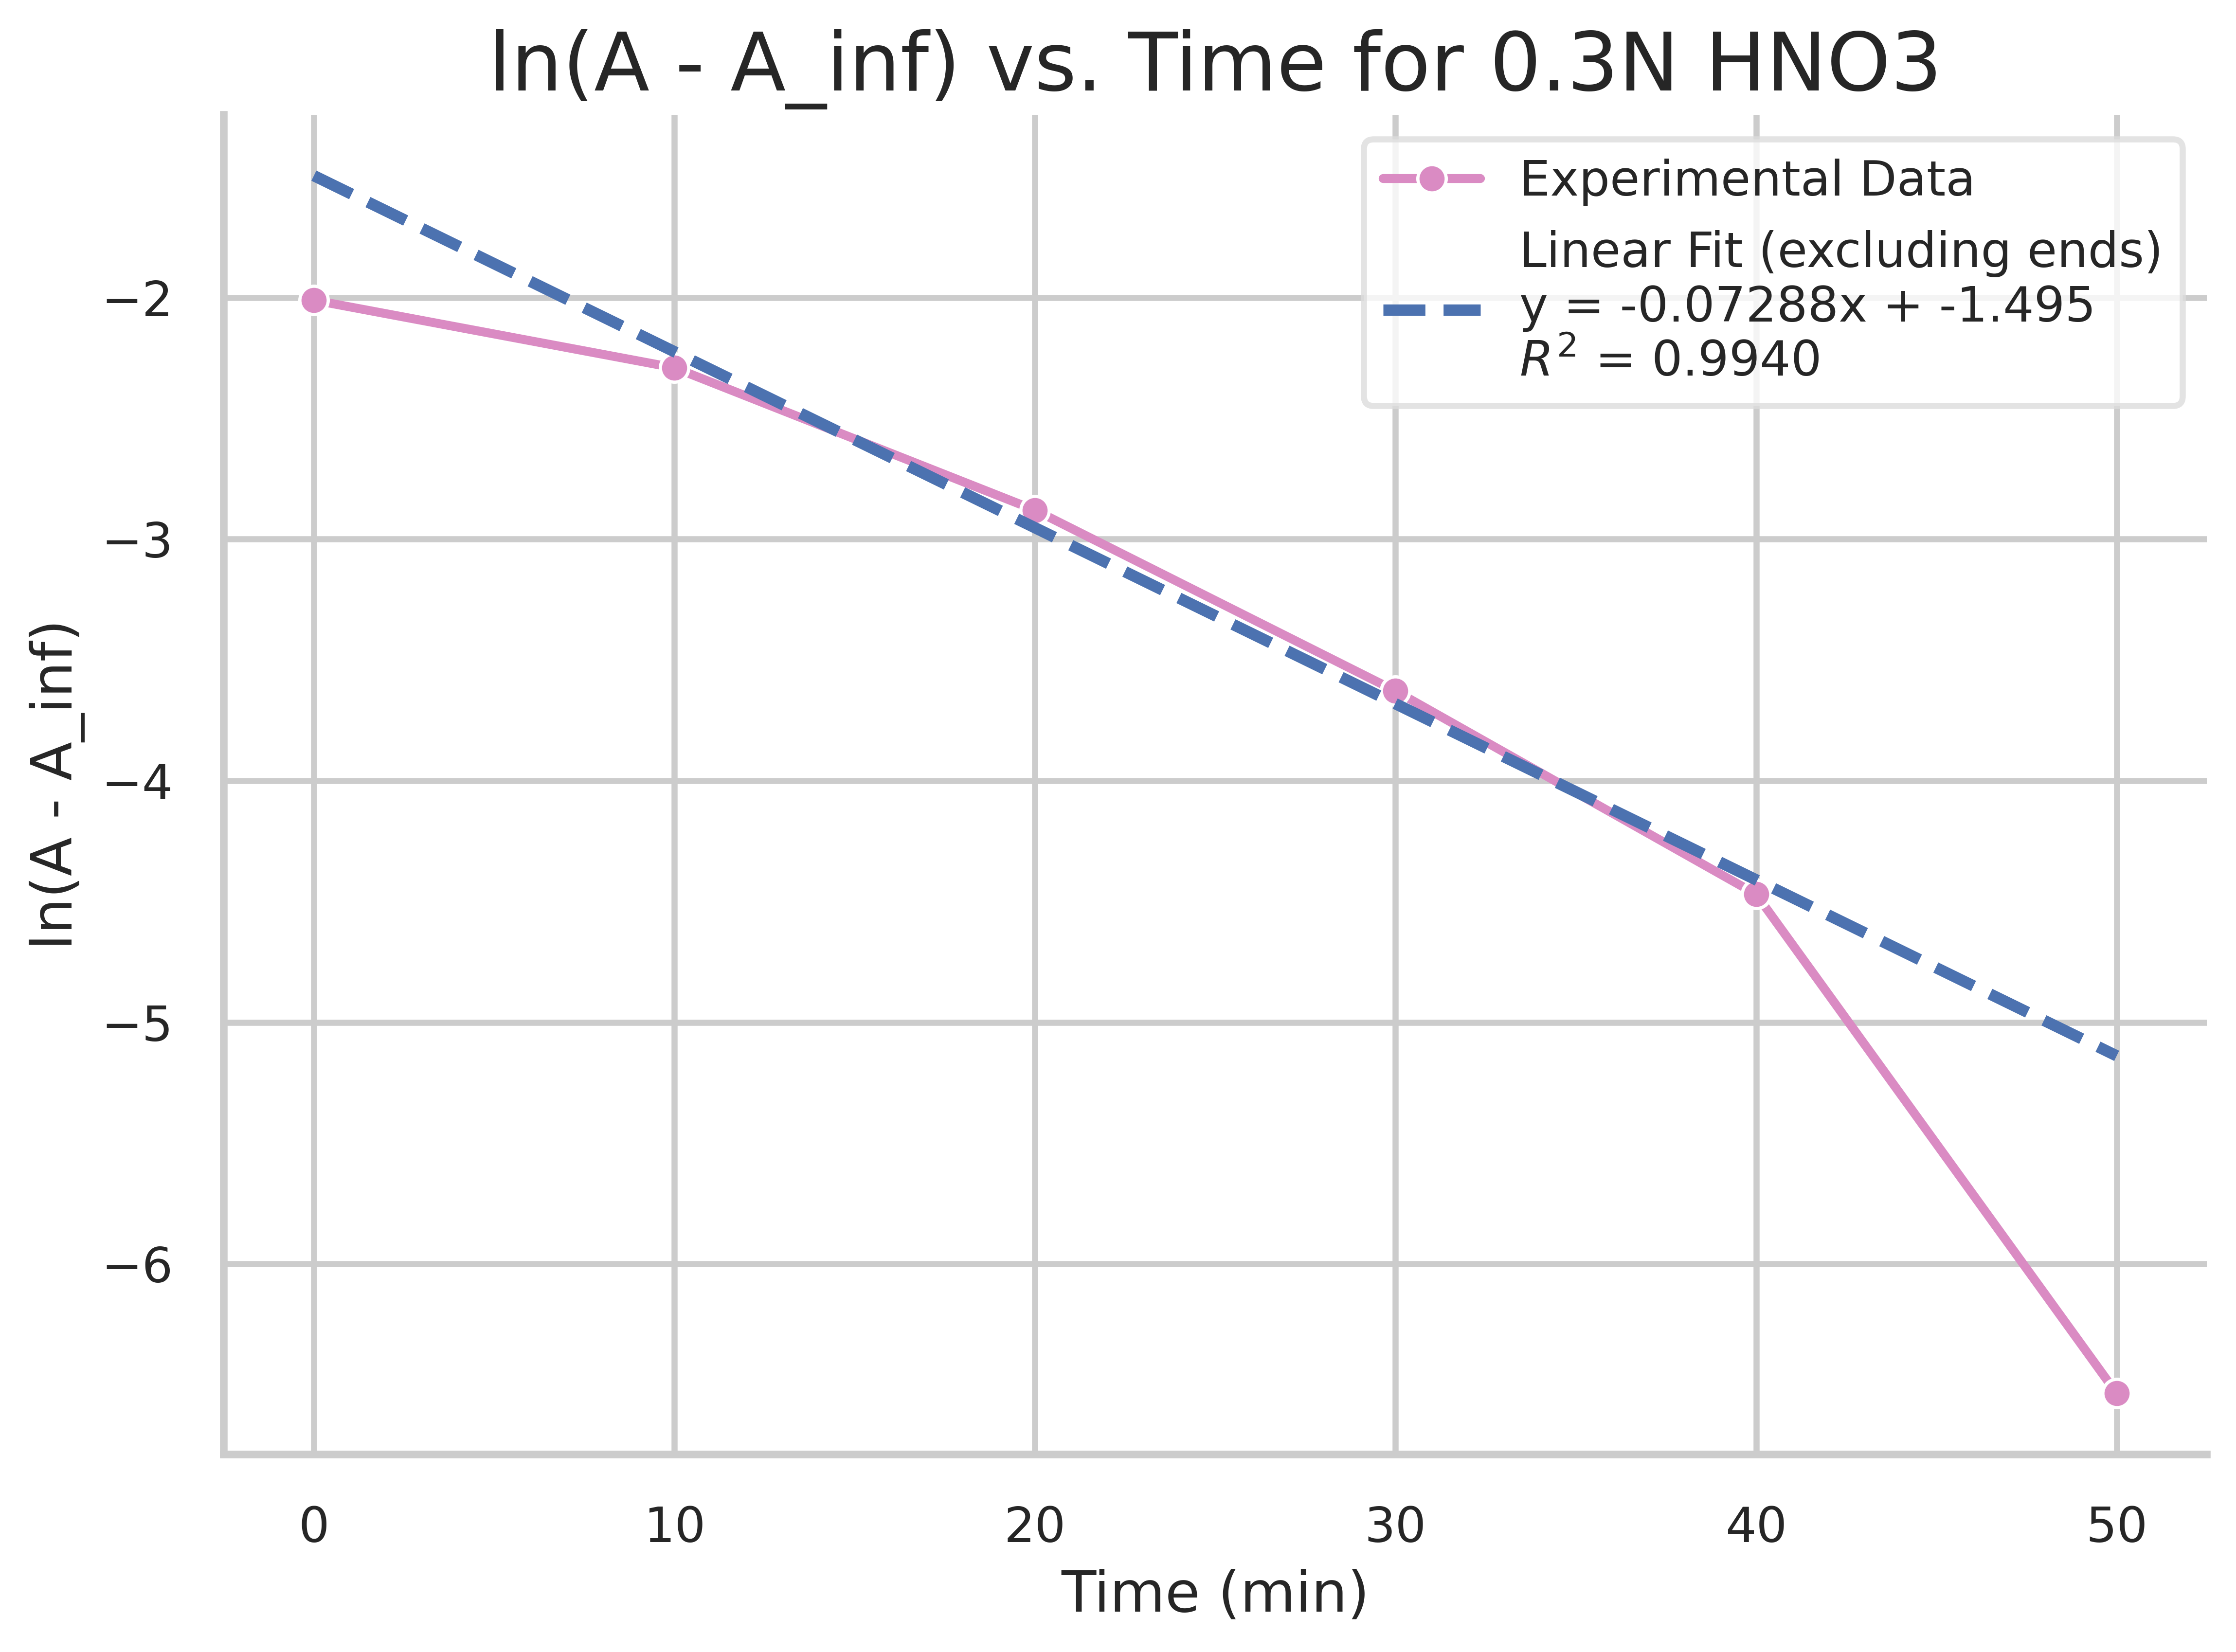

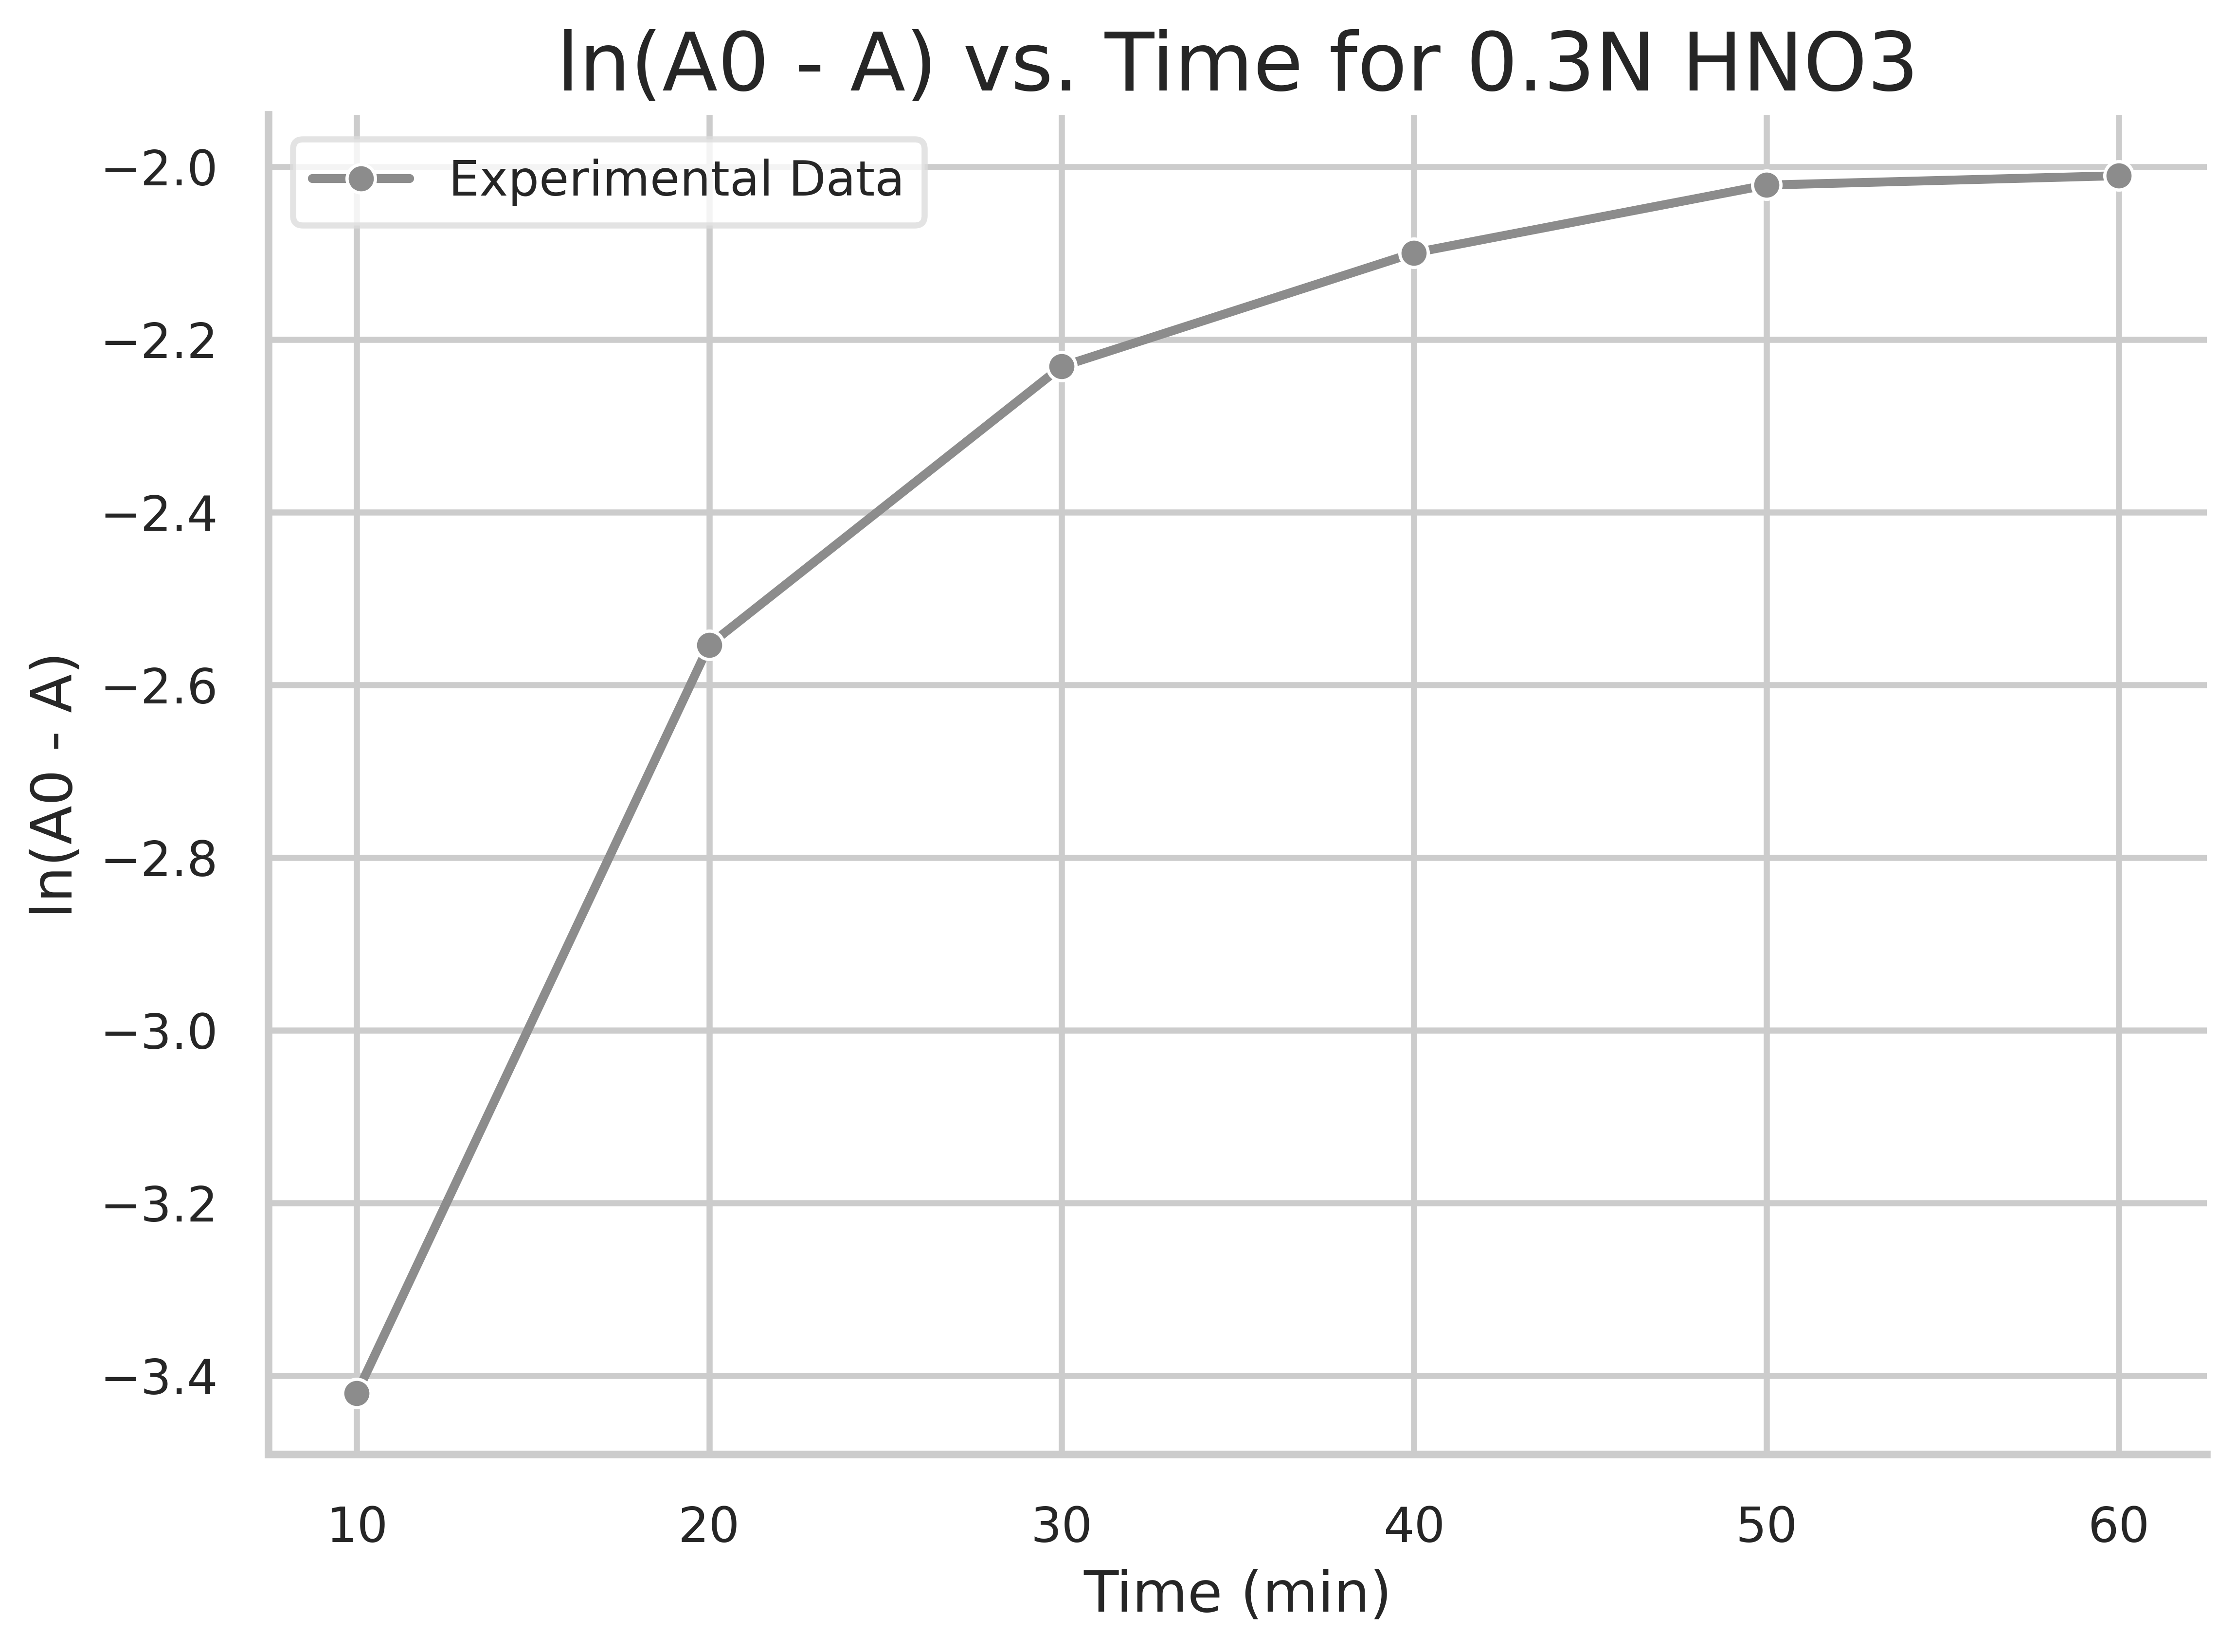

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme(style="whitegrid", context="talk")
PALETTE = sns.color_palette("deep", n_colors=8)

# --- 數據處理與計算 ---

df_01N = pd.DataFrame(data_01N)
df_03N = pd.DataFrame(data_03N)

# 設定 A0 (初始吸光度) 和 A_inf (最終吸光度)
A0_01N = df_01N['Absorbance'].iloc[0] if not df_01N.empty else None
A_inf_01N = df_01N['Absorbance'].iloc[-1] if not df_01N.empty else None
A0_03N = df_03N['Absorbance'].iloc[0] if not df_03N.empty else None
A_inf_03N = df_03N['Absorbance'].iloc[-1] if not df_03N.empty else None


print("--- 0.1 N HNO3 數據設定 ---")
print(f"A0 (初始吸光度) = {A0_01N}")
print(f"A_inf (最終吸光度) = {A_inf_01N}\n")
print("--- 0.3 N HNO3 數據設定 ---")
print(f"A0 (初始吸光度) = {A0_03N}")
print(f"A_inf (最終吸光度) = {A_inf_03N}\n")


def calculate_logs(df, A0, A_inf):
    df['ln(A)'] = np.log(df['Absorbance'])
    
    with np.errstate(divide='ignore'):  # 忽略 log(0) 的警告
        df['A - A_inf'] = df['Absorbance'] - A_inf
        df['ln(A - A_inf)'] = np.log(df['A - A_inf'])

        df['A0 - A'] = A0 - df['Absorbance']
        df['ln(A0 - A)'] = np.log(df['A0 - A'])
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

df_01N = calculate_logs(df_01N, A0_01N, A_inf_01N)
df_03N = calculate_logs(df_03N, A0_03N, A_inf_03N)


def plot_graph(df, x_col, y_col, title, add_regression=False, color_index=0):
    """通用繪圖函數"""
    plot_data = df[[x_col, y_col]].dropna().sort_values(by=x_col)
    primary_color = PALETTE[color_index % len(PALETTE)]
    regression_color = PALETTE[(color_index + 2) % len(PALETTE)]

    fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

    # 繪製所有的實驗數據點
    sns.lineplot(
        data=plot_data,
        x=x_col,
        y=y_col,
        ax=ax,
        color=primary_color,
        linewidth=2.2,
        marker="o",
        markersize=7,
        markerfacecolor=primary_color,
        markeredgewidth=0.8,
        markeredgecolor="white",
        label="Experimental Data"
    )

    # 如果需要，進行線性回歸
    if add_regression and len(plot_data) > 2: # 至少需要3個點才能排除頭尾
        
        # *** 修改處：選取數據的子集 (排除第一筆和最後一筆) 進行擬合 ***
        fit_data = plot_data.iloc[1:-1]
        
        if len(fit_data) > 1: # 確保子集仍有足夠數據點
            X_fit = fit_data[[x_col]]
            y_fit = fit_data[y_col]

            model = LinearRegression()
            model.fit(X_fit, y_fit)

            slope = model.coef_[0]
            intercept = model.intercept_
            r_squared = model.score(X_fit, y_fit) # R² 也基於子集計算

            # 為了繪製一條穿過整個圖表的線，使用完整數據的X範圍進行預測
            X_all = plot_data[[x_col]]
            sns.lineplot(
                x=plot_data[x_col],
                y=model.predict(X_all),
                ax=ax,
                color=regression_color,
                linewidth=2.8,
                linestyle="--",
                label=f"Linear Fit (excluding ends)\ny = {slope:.5f}x + {intercept:.3f}\n$R^2$ = {r_squared:.4f}"
            )

            print(f"--- 分析報告: {title} ---")
            print(f"  (已排除首尾數據點進行計算)")
            print(f"斜率 (slope): {slope:.5f}")
            print(f"速率常數 k_obs = {-slope:.5f} (min⁻¹)")
            print(f"R-squared 值: {r_squared:.4f}\n")

    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Time (min)', fontsize=14)
    ax.set_ylabel(y_col, fontsize=14)
    ax.tick_params(labelsize=12)
    ax.legend(frameon=True, facecolor="white", edgecolor="#dddddd", fontsize=12)
    sns.despine(ax=ax)
    fig.tight_layout()
    plt.show()

print("--- 0.1 N HNO3 系列圖 ---")
plot_graph(df_01N.copy(), 'Time (min)', 'Absorbance', 'Absorbance vs. Time for 0.1N HNO3', color_index=0)
plot_graph(df_01N.copy(), 'Time (min)', 'ln(A)', 'ln(A) vs. Time for 0.1N HNO3', color_index=1)
plot_graph(df_01N.copy(), 'Time (min)', 'ln(A - A_inf)', 'ln(A - A_inf) vs. Time for 0.1N HNO3', add_regression=True, color_index=2)
plot_graph(df_01N.copy(), 'Time (min)', 'ln(A0 - A)', 'ln(A0 - A) vs. Time for 0.1N HNO3', color_index=3)

print("\n--- 0.3 N HNO3 系列圖 ---")
plot_graph(df_03N.copy(), 'Time (min)', 'Absorbance', 'Absorbance vs. Time for 0.3N HNO3', color_index=4)
plot_graph(df_03N.copy(), 'Time (min)', 'ln(A)', 'ln(A) vs. Time for 0.3N HNO3', color_index=5)
plot_graph(df_03N.copy(), 'Time (min)', 'ln(A - A_inf)', 'ln(A - A_inf) vs. Time for 0.3N HNO3', add_regression=True, color_index=6)
plot_graph(df_03N.copy(), 'Time (min)', 'ln(A0 - A)', 'ln(A0 - A) vs. Time for 0.3N HNO3', color_index=7)

In [16]:
from IPython.display import display, HTML

# --- 表格 1: 0.1 N HNO3 ---

# 選取需要的欄位
table_01N = df_01N[['Time (min)', 'Absorbance', 'A - A_inf', 'ln(A - A_inf)', 'A0 - A', 'ln(A0 - A)']].copy()

# 重新命名欄位以符合圖片格式
table_01N.columns = [
    'Time (min)',
    'Absorbance (550 nm)',
    'A - A<sub>∞</sub>',
    'ln(A - A<sub>∞</sub>)',
    'A<sub>0</sub> - A',
    'ln(A<sub>0</sub> - A)'
]

# 設定表格樣式
styled_table_01N = table_01N.style.format({
    'Absorbance (550 nm)': '{:.5f}',
    'A - A<sub>∞</sub>': '{:.5f}',
    'ln(A - A<sub>∞</sub>)': '{:.4f}',
    'A<sub>0</sub> - A': '{:.5f}',
    'ln(A<sub>0</sub> - A)': '{:.4f}'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-size', '11pt')]},
    {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '11pt')]}
]).set_caption("<h3>0.1 N HNO₃</h3>").hide(axis='index')


# --- 表格 2: 0.3 N HNO3 ---

# 選取需要的欄位
table_03N = df_03N[['Time (min)', 'Absorbance', 'A - A_inf', 'ln(A - A_inf)', 'A0 - A', 'ln(A0 - A)']].copy()

# 重新命名欄位
table_03N.columns = [
    'Time (min)',
    'Absorbance (550 nm)',
    'A - A<sub>∞</sub>',
    'ln(A - A<sub>∞</sub>)',
    'A<sub>0</sub> - A',
    'ln(A<sub>0</sub> - A)'
]

# 設定表格樣式
styled_table_03N = table_03N.style.format({
    'Absorbance (550 nm)': '{:.5f}',
    'A - A<sub>∞</sub>': '{:.5f}',
    'ln(A - A<sub>∞</sub>)': '{:.4f}',
    'A<sub>0</sub> - A': '{:.5f}',
    'ln(A<sub>0</sub> - A)': '{:.4f}'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-size', '11pt')]},
    {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '11pt')]}
]).set_caption("<h3>0.3 N HNO₃</h3>").hide(axis='index')


# 顯示表格
display(styled_table_01N)
display(HTML("<br>")) # 增加間距
display(styled_table_03N)

Time (min),Absorbance (550 nm),A - A∞,ln(A - A∞),A0 - A,ln(A0 - A)
0,0.37154,0.12947,-2.0443,0.00000,nan
10,0.34453,0.10246,-2.2783,0.02701,-3.6115
20,0.29889,0.05682,-2.8679,0.07265,-2.6221
30,0.27272,0.03065,-3.4851,0.09882,-2.3145
40,0.25037,0.00830,-4.7915,0.12117,-2.1106
50,0.24429,0.00222,-6.1102,0.12725,-2.0616
60,0.24207,0.00000,nan,0.12947,-2.0443


Time (min),Absorbance (550 nm),A - A∞,ln(A - A∞),A0 - A,ln(A0 - A)
0,0.36401,0.13394,-2.0104,0.00000,nan
10,0.33132,0.10125,-2.2902,0.03269,-3.4207
20,0.28623,0.05616,-2.8796,0.07778,-2.5539
30,0.25663,0.02656,-3.6283,0.10738,-2.2314
40,0.24152,0.01145,-4.4698,0.12249,-2.0997
50,0.23152,0.00145,-6.5362,0.13249,-2.0212
60,0.23007,0.00000,nan,0.13394,-2.0104
